In [1]:
# Load in the packages
import numpy as np
import folktables
from folktables import ACSDataSource, ACSIncome

import os
import sys
import copy
sys.path.append('..')
import random
import FairCertModule
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms
from FullyConnected import FullyConnected
import pytorch_lightning as pl

# Set random seeds
SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
dataset = "Folk"
from sklearn.decomposition import PCA
def project_onto_2d_pca(data, data2):
    """
    Given a 2D array of shape (N, D), where N is the number of points and D is the number of dimensions,
    use sklearn PCA to project the data onto its two principal components, and return a 2D array of shape (N, 2).
    """
    pca = PCA(n_components=2)
    projected_data = pca.fit_transform(data)
    projected_data2 = pca.transform(data2)
    return projected_data, projected_data2



In [2]:
import folk_utils
X_1, _, _, y_1, _, _, _, _ = folk_utils.get_dataset(dataset)
X_2, _, _, y_2, _, _, _, _ = folk_utils.get_dataset(dataset, state="NY")

/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


In [3]:
#X_ca, X_ny = project_onto_2d_pca(X_1[0:1000], X_2[0:1000])
X_ca = X_1[0:10000].numpy(); X_ny = X_2[0:10000].numpy()

In [4]:
#import matplotlib
#import matplotlib.pyplot as plt
#plt.scatter(x=X_ca[:,0], y=X_ca[:,1], c='b')
#plt.scatter(x=X_ny[:,0], y=X_ny[:,1], c='r')

In [5]:
import ot
import ot.plot

In [15]:
from tqdm import trange, tqdm
states = ["AL", "AK", "AZ", "AR", "CO", "CT", "DE", "FL", "GA", 
      "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
      "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
      "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
      "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
n = 10000
a, b = np.ones((n,)) / n, np.ones((n,)) / n 
values = []
for state in tqdm(states):  
    X_other, _, _, _, _, _, _, _ = folk_utils.get_dataset(dataset, state=state)
    X_other = X_other.numpy()[0:10000]
    if(X_other.shape[-1] != 42):
        continue
    try:
        M = ot.dist(X_ca, X_other)
        n = len(X_ca)
        G0 = ot.emd2(a, b, M, numItermax=1000) - 0.13
        values.append(G0)
    except:
        continue

  0%|                                                    | 0/49 [00:00<?, ?it/s]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 1000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the co

 22%|█████████▋                                 | 11/49 [00:38<01:35,  2.52s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 1000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ot/lp/__init__.py:547: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
 24%|██████████▌                                | 12/49 [00:44<02:15,  3.66s/it]/Users/mattheww

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 1000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ot/lp/__init__.py:547: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
 43%|██████████████████▍                        | 21/49 [01:17<02:08,  4.58s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 45%|███████████████████▎                       | 22/49 [01:18<01:33,  3.48s/it]/Users/mattheww

 65%|████████████████████████████               | 32/49 [01:45<01:13,  4.31s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 67%|████████████████████████████▉              | 33/49 [01:45<00:48,  3.06s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = e

/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/ot/lp/__init__.py:547: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
 86%|████████████████████████████████████▊      | 42/49 [02:27<00:36,  5.16s/it]/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
 88%|█████████████████████████████████████▋     | 43/49 [02:27<00:22,  3.75s/it]/Users/m

In [16]:
print(values)

[0.33207367341518423, 0.34707602512836616, 0.314980125498772, 0.2925508597612391, 0.33065043776035263, 0.3429002258300775, 0.31470042643547164, 0.2809067749261866, 0.28073711836337945, 0.33730107271671267, 0.3335168082714081, 0.2797964911460873, 0.2793034070968632, 0.29780307466983785, 0.30014232559204085, 0.3482348428726196, 0.3063710922718043, 0.2843618992328631, 0.3206178906679137, 0.337398409581184, 0.2790296931743617, 0.30931845734119395, 0.3191952128171912, 0.32513401055336066, 0.31835969090461674, 0.33486493365764763, 0.29662751526832337]


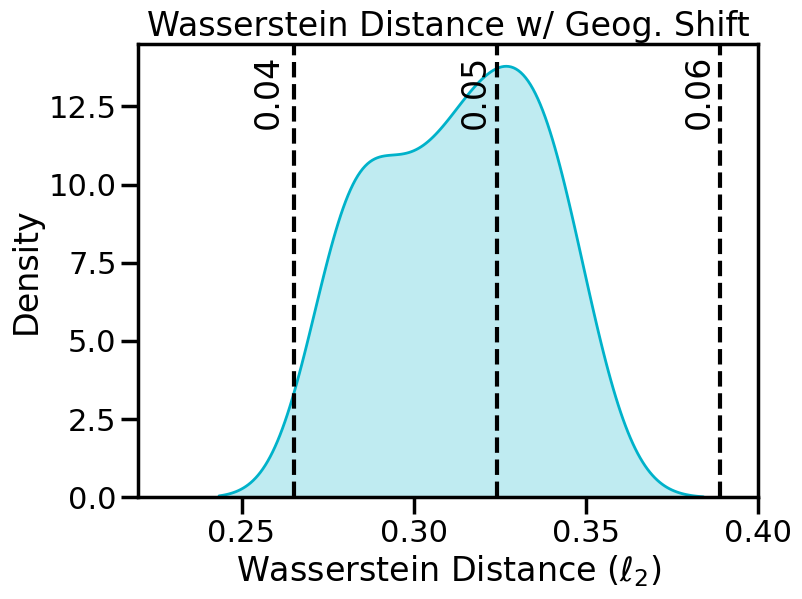

In [80]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
sns.kdeplot(values, fill=True, color="#00B2CA")
plt.axvline(x=0.26522, c='k', linestyle="--")
plt.text(0.253,12,'0.04',rotation=90,fontsize=24)
plt.axvline(x=0.32403, c='k', linestyle="--")
plt.text(0.313,12,'0.05',rotation=90,fontsize=24)
plt.axvline(x=0.38884, c='k', linestyle="--")
plt.text(0.378,12,'0.06',rotation=90,fontsize=24)
plt.xlim((0.22, 0.4))
plt.title("Wasserstein Distance w/ Geog. Shift")
plt.xlabel(r"Wasserstein Distance ($\ell_2$)")
plt.show()

In [24]:
print(X_ca.shape)
print(np.linalg.norm([0.06 for i in range(42)]))

(10000, 42)
0.3888444419044716
